In [2]:
import os
import albumentations as A
from dataset import SynData, COCO_DETECTION
from copy_paste import InstanceCopyPaste, InstanceRetriever
import random
import colorsys

import numpy as np
from skimage.measure import find_contours
import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Polygon
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
syn_dataset = SynData(os.environ.get("SYN_DATA_DIR"), {"car": 2, "bus": 1, "boat": 3})
instance_retriever = InstanceRetriever(syn_dataset)
import albumentations as A

transform = A.Compose(
    [
        A.RandomScale(
            scale_limit=(-0.9, 1), p=1
        ),  # LargeScaleJitter from scale of 0.1 to 2
        A.PadIfNeeded(
            512, 512, border_mode=0
        ),  # pads with image in the center, not the top left like the paper
        A.Resize(512, 512),
    ],
    bbox_params=A.BboxParams(
        format="coco", min_visibility=0.05, label_fields=["labels"]
    ),
)

dataset = COCO_DETECTION(
    os.environ.get("COCO_DATA_DIR_VAL"),
    "../car_boat_bus_val.json",
    categories=["boat", "car", "bus"],
    transform=transform,
    instance_copy_paste=InstanceCopyPaste(instance_retriever, "random", 5, 0.5, 20),
)

loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


In [4]:
def random_colors(N, bright=True):
    """
    Generate random colors.
    To get visually distinct colors, generate them in HSV space then
    convert to RGB.
    """
    brightness = 1.0 if bright else 0.7
    hsv = [(i / N, 1, brightness) for i in range(N)]
    colors = list(map(lambda c: colorsys.hsv_to_rgb(*c), hsv))
    random.shuffle(colors)
    return colors


def apply_mask(image, mask, color, alpha=0.5):
    """Apply the given mask to the image."""
    for c in range(3):
        image[:, :, c] = np.where(
            mask == 1,
            image[:, :, c] * (1 - alpha) + alpha * color[c] * 255,
            image[:, :, c],
        )
    return image

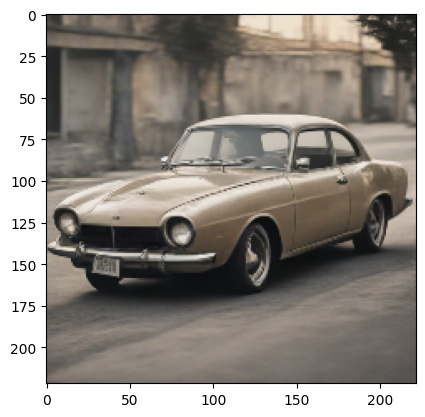

In [8]:
plt.imshow(instance_retriever.get_instances(8)[0]["image"])

In [ ]:
len(dataset)

In [ ]:
img, test = dataset[random.randint(0, len(dataset) - 1)]

In [ ]:
test.keys()

In [ ]:
mapping = {"car": 2, "bus": 1, "boat": 3}
reversed_mapping = {value: key for key, value in mapping.items()}
print(reversed_mapping)


In [ ]:
img, test = dataset[random.randint(0, len(dataset) - 1)]

f, ax = plt.subplots(1, 2)
img = img.permute(1, 2, 0).numpy()
ax[0].imshow(img/255)
ax[0].axis("off")
if len(test["boxes"]) == 0:
    pass
else:
    for i, mask in enumerate(test["masks"]):
        color = random_colors(1)[0]
        img = apply_mask(img, mask.detach().numpy(), color)
        ax[1].imshow(img/255)

        x1, y1, x2, y2 = test["boxes"][i]
        rect = patches.Rectangle(
            (x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor="r", facecolor="none"
        )
        ax[1].add_patch(rect)

        # Add text to the rectangle
        label = reversed_mapping[test["labels"][i].item()]
        ax[1].text(x1, y1, label, color="r", fontsize=12, weight="bold")
        ax[1].axis("off")

    plt.tight_layout()
    plt.axis("off")
    plt.show()